# Encoder-Decoder Image Captioning

### Install Necessary Dependencies

In [1]:
%pip install nltk
%pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00


In [2]:
!mkdir models

## Initialize the COCO API

In [3]:
# import libraries
import os
import sys
import json
import math
import nltk
import torch
import wandb
import urllib
import random
import pickle
import zipfile
import numpy as np
from tqdm import tqdm
from PIL import Image
import skimage.io as io
from collections import Counter
import matplotlib.pyplot as plt
import torch.utils.data as data
from pycocotools.coco import COCO
from torchvision import transforms
from model import Encoder, Decoder

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 20.11 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [5]:
os.chdir('/content/opt/cocoapi')

# Download the annotation :
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7c6996a061a0>)

In [6]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [7]:
os.chdir('/content/opt/cocoapi/annotations')

dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)


instances_val2014.json
loading annotations into memory...
Done (t=13.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [8]:
ids = list(coco.anns.keys())

In [9]:
list(coco.anns.values())[0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

## Plot A Sample Image from COCO Dataset

http://images.cocodataset.org/val2014/COCO_val2014_000000330110.jpg
Number of annotations i.e captions for the image:  [340975, 341323, 342715, 343513, 346663]

Hot dogs on a portable grill at the beach
Some hot dogs are being grilled in a metal pan.
a line of hot dogs sit on a tray 
Seven hot dogs cook on charcoal on the sandy beach.
Hot dogs are being cooked on a makeshift grill at the beach.


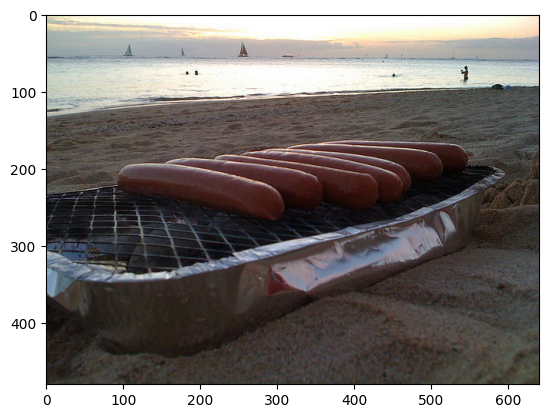

In [10]:
# pick random image with annotation id
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
print('Number of annotations i.e captions for the image: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

In [11]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'

urllib.request.urlretrieve(train2014 , 'train2014')
urllib.request.urlretrieve(test2014 , 'test2014')

('test2014', <http.client.HTTPMessage at 0x7c68a8f2f370>)

In [12]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None


os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [13]:
class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [14]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary.
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """

    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset,
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):

    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word,
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [15]:

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 200

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

loading annotations into memory...
Done (t=1.10s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.10s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:48<00:00, 8619.41it/s]


In [16]:
counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val, count in lengths:
  print('value: %2d --- count: %5d' % (val, count))
  if count < 10000:
    break

value: 10 --- count: 86302
value: 11 --- count: 79971
value:  9 --- count: 71920
value: 12 --- count: 57653
value: 13 --- count: 37668
value: 14 --- count: 22342
value:  8 --- count: 20742
value: 15 --- count: 12839
value: 16 --- count:  7736


In [17]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [272310, 299619, 257630, 107394, 190190, 321463, 224337, 305501, 242248, 21921, 209470, 409904, 20085, 21719, 287324, 351168, 171022, 345704, 4741, 49106, 40852, 178083, 99943, 283992, 341003, 298887, 391461, 275170, 259118, 80584, 169513, 277431, 88150, 200956, 121397, 252735, 77456, 394332, 116276, 13528, 108923, 179378, 203995, 368621, 398920, 94187, 14484, 67062, 315667, 347776, 140928, 277280, 135216, 162830, 103606, 65244, 343484, 161036, 259104, 38924, 91982, 278933, 205873, 60161, 313317, 238691, 27214, 72349, 411424, 154323, 149197, 308490, 159962, 63555, 175295, 46417, 85130, 50341, 333918, 317618, 355836, 302981, 342356, 334261, 360219, 106748, 11884, 337751, 397344, 391680, 38571, 389450, 111742, 399865, 193871, 184436, 13655, 291250, 347357, 266844, 320826, 224222, 282172, 200671, 408904, 2840, 355589, 206533, 85744, 318171, 152861, 312689, 90176, 136531, 199265, 275472, 222480, 68151, 290004, 52593, 264296, 350592, 167082, 379137, 223499, 352147, 97801, 16

In [18]:
## Select appropriate values for the Python variables below.
batch_size = 10          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True      # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

# (Optional)  Amend the image transform below.
transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# # Build data loader.
# data_loader = get_loader(transform=transform_train,
#                          mode='train',
#                          batch_size=batch_size,
#                          vocab_threshold=vocab_threshold,
#                          vocab_from_file=False,
#                          cocoapi_loc = '/content/opt')

# The size of the vocabulary.
vocab_size = len(data_loader_train.dataset.vocab)

# Initialize the encoder and decoder.
encoder = Encoder(embed_size)
decoder = Decoder(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function.
criterion = torch.nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else torch.nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters())+list(encoder.embed.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params,lr=0.0001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [19]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Image Captioning Encoder-Decoder Architecture",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "EncodeCNN-DecoderRNN",
    "dataset": "COCO2014",
    "epochs": num_epochs,
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
for epoch in range(1, num_epochs+1):
    for i_step in range(1, total_step+1):
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader_train.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader_train.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader_train))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        # Log to wandb
        wandb.log({"perplexity": np.exp(loss.item()), "loss": loss.item()})

        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()

        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)

    # Save the weights.
    if epoch % save_every == 0:
        models_dir = './models'
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
        torch.save(decoder.state_dict(), os.path.join(models_dir, 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join(models_dir, 'encoder-%d.pkl' % epoch))
wandb.finish()

Epoch [1/3], Step [100/2071], Loss: 5.3093, Perplexity: 202.2171
Epoch [1/3], Step [200/2071], Loss: 4.9541, Perplexity: 141.7525
Epoch [1/3], Step [300/2071], Loss: 5.0704, Perplexity: 159.2392
Epoch [1/3], Step [400/2071], Loss: 4.0937, Perplexity: 59.9636
Epoch [1/3], Step [500/2071], Loss: 4.0123, Perplexity: 55.2757
Epoch [1/3], Step [600/2071], Loss: 4.2026, Perplexity: 66.8578
Epoch [1/3], Step [700/2071], Loss: 3.7169, Perplexity: 41.1349
Epoch [1/3], Step [800/2071], Loss: 4.0334, Perplexity: 56.4516
Epoch [1/3], Step [900/2071], Loss: 3.4925, Perplexity: 32.8688
Epoch [1/3], Step [1000/2071], Loss: 3.4692, Perplexity: 32.1119
Epoch [1/3], Step [1100/2071], Loss: 4.1488, Perplexity: 63.3570
Epoch [1/3], Step [1200/2071], Loss: 3.4651, Perplexity: 31.9785
Epoch [1/3], Step [1300/2071], Loss: 3.2912, Perplexity: 26.8757
Epoch [1/3], Step [1400/2071], Loss: 3.3578, Perplexity: 28.7262
Epoch [1/3], Step [1500/2071], Loss: 3.2748, Perplexity: 26.4378
Epoch [1/3], Step [1600/2071], 

loss,█▆▅▅▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▂▁▂▁▂
perplexity,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,2.42069
perplexity,11.2536


In [23]:
transform_test = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader_test = get_loader(transform=transform_test, mode='test', cocoapi_loc = '/content/opt')

Vocabulary successfully loaded from vocab.pkl file!


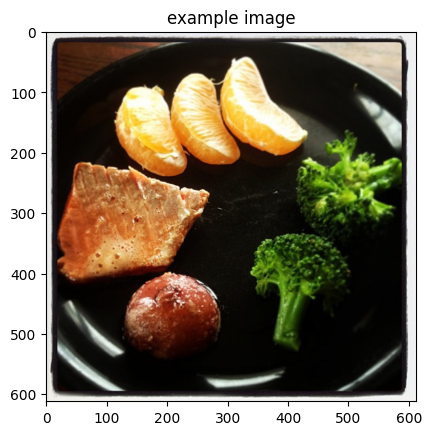

In [24]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader_test))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_test.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = Encoder(embed_size)
encoder.eval()
decoder = Decoder(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Decoder(
  (word_embedding): Embedding(7072, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=7072, bias=True)
)

In [27]:
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

example output: [0, 3, 808, 13, 108, 21, 3, 670, 13, 2397, 6, 3, 2960, 18]


In [28]:
def clean_sentence(output):
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(data_loader_test.dataset.vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end>

    sentence = ' '.join(cleaned_list) # Convert list of string to
    sentence = sentence.capitalize()
    return sentence

In [29]:
def get_prediction():
    orig_image, image = next(iter(data_loader_test))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    print(sentence)

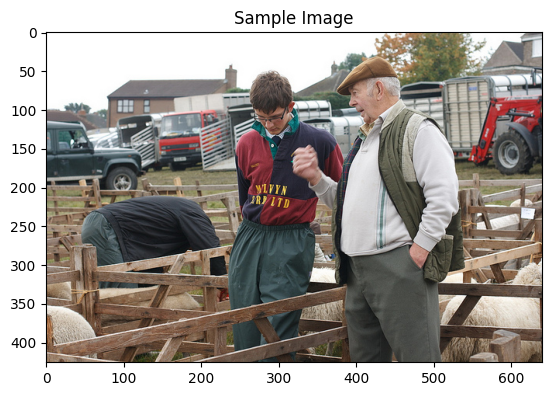

A man standing next to a woman holding a cell phone


In [30]:
get_prediction()

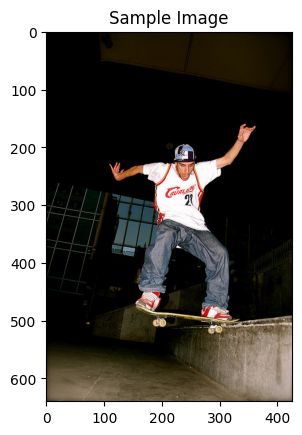

A man is doing a trick on a skateboard


In [31]:
get_prediction()

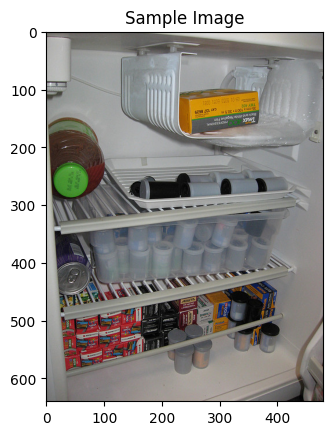

A white refrigerator with a bunch of different types of food


In [32]:
get_prediction()

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
# save whole train folder to Google Drive
%cp -r "/content/opt/cocoapi/models" "/content/gdrive/MyDrive/fyp_models"